Epoch 1/1500
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 3310544148758528.0000 - val_loss: 3180674269839360.0000
Epoch 2/1500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3068369733419008.0000 - val_loss: 3180630783295488.0000
Epoch 3/1500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3016142931099648.0000 - val_loss: 3180397781319680.0000
Epoch 4/1500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2897814703046656.0000 - val_loss: 3179641598640128.0000
Epoch 5/1500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3228247475093504.0000 - val_loss: 3177751276158976.0000
Epoch 6/1500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3386694992658432.0000 - val_loss: 3173792390053888.0000
Epoch 7/1500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3319656458747904.0000 - val_loss: 3166691735371776.0000
Epoch 8/1500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2829772220530688.0000 - val_loss: 3154660995104768.0000
Epoch 9/1500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 335

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Топ-10 признаков по важности:
                                Feature  Importance
30                     district_Раменки    0.564418
68   underground_Ломоносовский проспект    0.549024
12                 district_Даниловский    0.530758
102         underground_Улица 1905 года    0.527239
0                          total_meters    0.506688
34                    district_Тверской    0.472425
75              underground_Москва-Сити    0.464884
35              district_Филевский парк    0.460414
103                    underground_Фили    0.458912
21                   district_Мещанский    0.454387


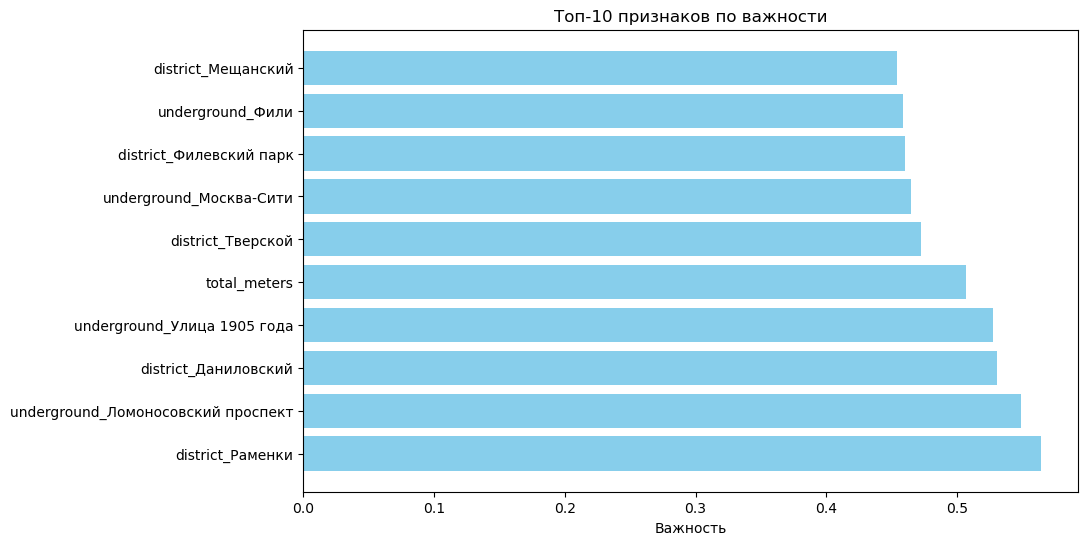

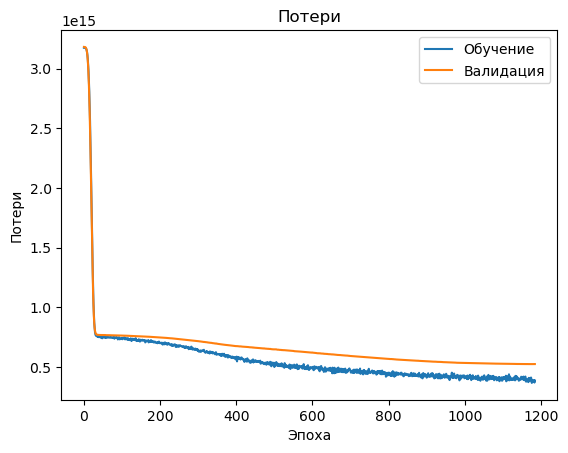

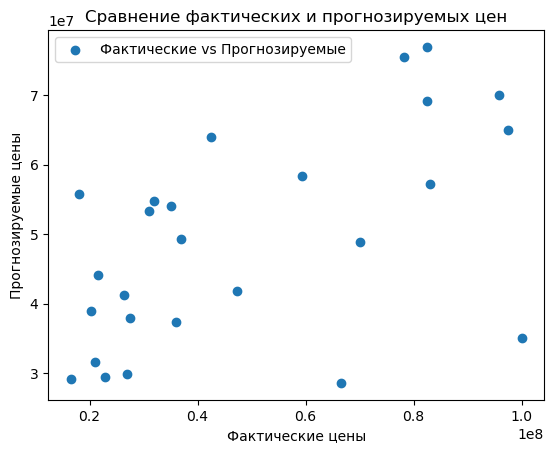

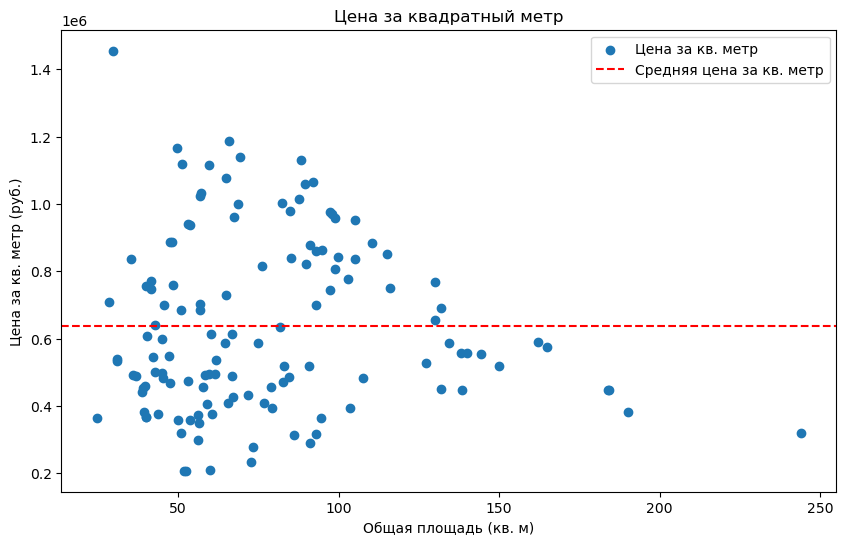

NameError: name 'create_model' is not defined

In [21]:
import os
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.callbacks import EarlyStopping

# Определяем путь к папке Sale
sale_folder = os.path.join(os.getcwd(), 'Sale')

# Находим все CSV файлы с 'sale' в названии в папке Sale
csv_files = glob.glob(os.path.join(sale_folder, '*sale*.csv'))

# Проверка наличия файлов
if not csv_files:
    raise FileNotFoundError("В папке 'Sale' нет CSV файлов с 'sale' в названии.")

# Сортировка файлов по времени создания и выбор последнего
latest_file = max(csv_files, key=os.path.getctime)

# Загрузка данных из последнего файла
data = pd.read_csv(latest_file, sep=',')

# Проверка наличия необходимых колонок
required_columns = ['total_meters', 'rooms_count', 'floor', 'floors_count', 'district', 'underground', 'price']
for col in required_columns:
    if col not in data.columns:
        raise KeyError(f"Отсутствует колонка: {col}")

# Выбор признаков и целевой переменной
features = ['total_meters', 'rooms_count', 'floor', 'floors_count', 'district', 'underground']
X = data[features]
y = data['price']

# Обработка категориальных признаков
categorical_features = ['district', 'underground']
numerical_features = ['total_meters', 'rooms_count', 'floor', 'floors_count']

# Создание трансформеров для числовых и категориальных данных
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Объединение трансформеров в колонный трансформер
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Преобразование данных
X = preprocessor.fit_transform(X)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Преобразование данных для использования в CNN
X_train = X_train.toarray().reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.toarray().reshape((X_test.shape[0], X_test.shape[1], 1))

# Определение модели
model = Sequential()
model.add(Input(shape=(X_train.shape[1], 1)))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))  # Dropout для регуляризации
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))  # Еще один Dropout
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))  # L2-регуляризация
model.add(Dense(1))

# Компиляция модели
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Обучение модели с уменьшенным размером батча и увеличенным количеством эпох
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=1500, validation_data=(X_test, y_test), batch_size=5, callbacks=[early_stopping])

# Оценка модели
loss = model.evaluate(X_test, y_test)
print(f'Потери на тестовых данных: {loss}')

# Прогнозирование цен на тестовых данных
predictions = model.predict(X_test)

# Пример вывода первых 10 прогнозов
for i in range(10):
    print(f'Фактическая цена: {y_test.iloc[i]}, Прогнозируемая цена: {predictions[i][0]}')

# Рассчет средней стоимости 1 кв. метра
data['price_per_sqm'] = data['price'] / data['total_meters']
average_price_per_sqm = data['price_per_sqm'].mean()
print(f'Средняя стоимость 1 кв. метра: {average_price_per_sqm}')

# Прогнозирование на 3 года вперед
future_dates = ['2025-09-23', '2026-09-23', '2027-09-23']
future_predictions = model.predict(X_test[:1])  # Предположительно использовать реальные данные для будущего

for date in future_dates:
    print(f'Дата: {date}, Прогнозируемая цена за кв. метр: {future_predictions[0][0]}')

# Важность признаков
importance_model = Sequential()
importance_model.add(Dense(1, input_shape=(X_train.shape[1],)))
importance_model.compile(optimizer='adam', loss='mean_squared_error')
importance_model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1]), y_train, epochs=50, batch_size=10, verbose=0)

# Получаем важность признаков
feature_importances = np.abs(importance_model.layers[0].get_weights()[0]).flatten()
categorical_feature_names = list(preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features))
feature_names = numerical_features + categorical_feature_names

if len(feature_names) != len(feature_importances):
    raise ValueError("Количество признаков и их важность не совпадает.")

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Выводим топ-10 признаков
top_10_importance = importance_df.head(10)
print("Топ-10 признаков по важности:")
print(top_10_importance)

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
plt.barh(top_10_importance['Feature'], top_10_importance['Importance'], color='skyblue')
plt.xlabel('Важность')
plt.title('Топ-10 признаков по важности')
plt.show()

# График потерь
plt.plot(history.history['loss'], label='Обучение')
plt.plot(history.history['val_loss'], label='Валидация')
plt.title('Потери')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()
plt.show()

# График сравнения фактических и прогнозируемых цен
plt.scatter(y_test, predictions, label='Фактические vs Прогнозируемые')
plt.xlabel('Фактические цены')
plt.ylabel('Прогнозируемые цены')
plt.legend()
plt.title('Сравнение фактических и прогнозируемых цен')
plt.show()

# График цены за кв. метр
plt.figure(figsize=(10, 6))
plt.scatter(data['total_meters'], data['price_per_sqm'], label='Цена за кв. метр')
plt.axhline(y=average_price_per_sqm, color='r', linestyle='--', label='Средняя цена за кв. метр')
plt.xlabel('Общая площадь (кв. м)')
plt.ylabel('Цена за кв. метр (руб.)')
plt.title('Цена за квадратный метр')
plt.legend()
plt.show()

# Кросс-валидация с подбором гиперпараметров
model_cv = KerasRegressor(build_fn=create_model, epochs=100, batch_size=10, verbose=0)

# Параметры для поиска
param_grid = {
    'batch_size': [10, 20],
    'epochs': [50, 100]
}

# Grid Search для подбора гиперпараметров
grid = GridSearchCV(estimator=model_cv, param_grid=param_grid, scoring=make_scorer(mean_absolute_error), cv=3)
grid_result = grid.fit(X_train, y_train)

# Вывод лучших параметров
print(f"Лучшие параметры: {grid_result.best_params_}")